In [26]:
import geopandas as gpd
from shapely.geometry import Point
import pyvista as pv
import warnings

# Desactiva todos los warnings
warnings.filterwarnings("ignore")
# Cargar las curvas de nivel desde un Shapefile
curvas_nivel = gpd.read_file('data/Maqueta')
edificaciones_gdf = gpd.read_file('./data/construcciones_maqueta')
edificaciones_gdf.dropna(subset=['geometry'], inplace=True)

In [28]:
edificaciones_gdf.rename(columns={'Metros': 'Height'}, inplace=True)

In [59]:
from shapely.geometry import Polygon, MultiPolygon
import pyvista as pv

def create_prism_mesh_and_sides(input_polygon, height, h0=0):
    # Verificar si es un MultiPolygon y convertirlo a una lista de polígonos si es necesario
    if isinstance(input_polygon, MultiPolygon):
        polygons = list(input_polygon.geoms)
    elif isinstance(input_polygon, Polygon):
        polygons = [input_polygon]
    else:
        raise ValueError("Input debe ser un Polygon o MultiPolygon")

    # Inicializar una lista para almacenar los resultados de cada polígono
    result_meshes = []

    # Iterar sobre los polígonos
    for polygon in polygons:
        # Extraer los puntos x, y del polígono
        x, y = polygon.exterior.coords.xy

        # Crear los puntos para las caras superiores e inferiores
        top_points = [(xi, yi, height + h0) for xi, yi in zip(x, y)]
        bottom_points = [(xi, yi, h0) for xi, yi in zip(x, y)]

        # Combinar los puntos en una lista
        points = bottom_points[:-1] + top_points[:-1]

        # Calcular el número de puntos en el polígono
        num_points = len(polygon.exterior.coords) - 1

        # Crear las caras de la malla
        faces = [
            [num_points] + list(range(num_points)),             # Cara inferior
            [num_points] + list(range(num_points, 2 * num_points))  # Cara superior
        ]

        # Crear la malla principal del prisma
        main_mesh = pv.PolyData(points, faces)
        main_mesh.texture_map_to_plane(inplace=True)

        # Lista para guardar las mallas de las caras laterales
        side_meshes = []

        # Crear mallas para cada cara lateral
        for i in range(num_points):
            side_points = [
                points[i], points[(i + 1) % num_points],
                points[(i + 1) % num_points + num_points], points[i + num_points]
            ]
            side_faces = [[4, 0, 1, 2, 3]]  # Un cuadrilátero por cada cara lateral
            side_mesh = pv.PolyData(side_points, side_faces)

            # Asignar coordenadas de textura
            side_mesh.texture_map_to_plane(inplace=True)

            side_meshes.append(side_mesh)

        # Agregar el resultado de este polígono a la lista de resultados
        result_meshes.append((main_mesh, side_meshes))

    return result_meshes


In [60]:
def obtener_limites_geodf(geodf):
    """
    Calcula los límites espaciales (x_min, x_max, y_min, y_max) de un GeoDataFrame.

    :param geodf: GeoDataFrame con geometrías LineString.
    :return: Tupla con los valores (x_min, x_max, y_min, y_max).
    """
    x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

    for linea in geodf.geometry:
        bounds = linea.bounds
        x_min, y_min = min(x_min, bounds[0]), min(y_min, bounds[1])
        x_max, y_max = max(x_max, bounds[2]), max(y_max, bounds[3])

    return x_min, x_max, y_min, y_max

def limites_a_puntos_geodf(x_min, x_max, y_min, y_max):
    """
    Convierte los límites en un GeoDataFrame con los cuatro puntos de esquina.

    :param x_min: Límite mínimo en el eje X.
    :param x_max: Límite máximo en el eje X.
    :param y_min: Límite mínimo en el eje Y.
    :param y_max: Límite máximo en el eje Y.
    :return: GeoDataFrame con los cuatro puntos de esquina.
    """
    # Crear los puntos de esquina
    puntos = [
        Point(x_min, y_min),
        Point(x_min, y_max),
        Point(x_max, y_min),
        Point(x_max, y_max)
    ]

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=puntos)

    return gdf
# Uso de la función
# Suponiendo que 'curvas_nivel' es tu GeoDataFrame de curvas de nivel
x_min, x_max, y_min, y_max = obtener_limites_geodf(curvas_nivel)
esquinas_gdf = limites_a_puntos_geodf(x_min, x_max, y_min, y_max)


<Axes: >

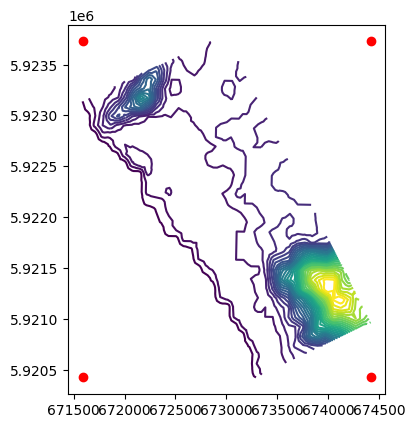

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
curvas_nivel.plot(ax=ax,column='CONTOUR')
esquinas_gdf.plot(ax=ax, color='red')

In [62]:
import numpy as np
import pyvista as pv
from scipy.interpolate import griddata
import geopandas as gpd

def generar_mesh_dentro_del_poligono(poligono):
    """
    Genera un gran número de puntos y filtra los que están dentro de un polígono.

    :param poligono: Polígono (Shapely Polygon).
    :return: Lista de puntos (numpy array) dentro del polígono.
    """
    minx, miny, maxx, maxy = poligono.bounds
    grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

    return grid_x, grid_y

def generar_malla_terreno(curvas_nivel, edificaciones_gdf, x_min, x_max, y_min, y_max):
    """
    Genera una malla de terreno a partir de curvas de nivel.

    :param curvas_nivel: GeoDataFrame de curvas de nivel.
    :param x_min: Límite mínimo en el eje X.
    :param x_max: Límite máximo en el eje X.
    :param y_min: Límite mínimo en el eje Y.
    :param y_max: Límite máximo en el eje Y.
    :return: Malla de terreno (PyVista StructuredGrid).
    """
    # Descomponer geometrías multiparte en geometrías individuales
    curvas_nivel = curvas_nivel.explode()

    puntos = []
    elevaciones = []

    for index, row in curvas_nivel.iterrows():
        # Extraer las coordenadas x, y, z de cada línea
        for x, y, z in np.array(row['geometry'].coords):
            puntos.append([x, y])
            elevaciones.append(row['CONTOUR'])  # Usar el valor de CONTOUR como elevación

    # Crear una cuadrícula regular para la interpolación
    grid_x, grid_y = [], []
    det_grid_x, det_grid_y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]
    grid_x.append(det_grid_x)
    grid_y.append(det_grid_y)

    # for index, row in edificaciones_gdf.iterrows():
    #     # print(row['geometry'])
    #     gx, gy = generar_mesh_dentro_del_poligono(row['geometry'])
    #     grid_x.append(gx)
    #     grid_y.append(gy)

    grid_x = np.concatenate(grid_x)
    grid_y = np.concatenate(grid_y)

    # Interpolar los datos de elevación en la cuadrícula
    grid_z = griddata(puntos, elevaciones, (grid_x, grid_y), method='cubic')

    # Crear una malla PyVista con la cuadrícula interpolada
    return pv.StructuredGrid(grid_x, grid_y, grid_z)

# Uso de la función
x_min, x_max, y_min, y_max = obtener_limites_geodf(curvas_nivel)
# print(x_min, x_max, y_min, y_max)
malla_terreno = generar_malla_terreno(curvas_nivel, edificaciones_gdf, x_min, x_max, y_min, y_max)

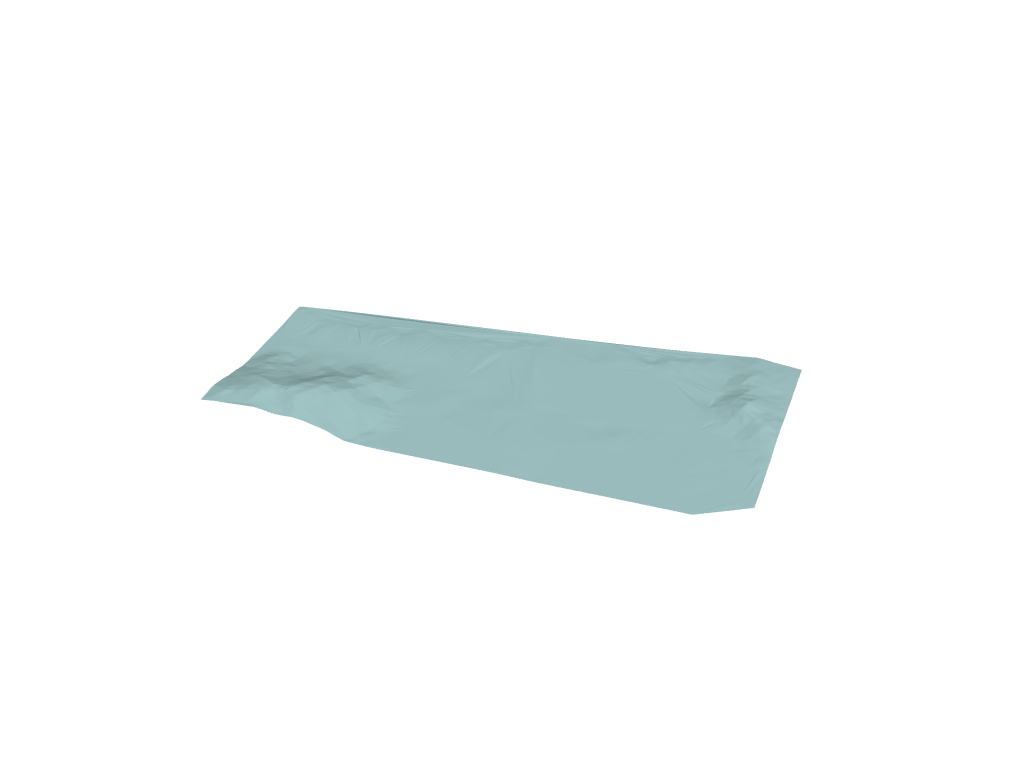

In [63]:
import pyvista as pv

# Crea una ventana de visualización
plotter = pv.Plotter()

# Agrega la malla de terreno a la ventana de visualización
plotter.add_mesh(malla_terreno, cmap="viridis")

# Configura la cámara
plotter.camera_position = "iso"

# Muestra la ventana de visualización
plotter.show()


In [64]:
# Define la ruta donde deseas guardar el archivo VTK
ruta_vtk = "./data/malla_terreno.vtk"

# Guarda la malla en formato VTK
malla_terreno.save(ruta_vtk)

In [65]:
import pandas as pd
from shapely.geometry import Point
points_array = np.array(malla_terreno.points_matrix)
new_dims = (points_array.shape[0]*points_array.shape[1], points_array.shape[3])
# print(new_dims)
points_array = points_array.reshape(new_dims)
points_df = pd.DataFrame(points_array).dropna(subset=[2]).rename(columns={0:'x', 1:'y', 2: 'z'})
points_df['geometry'] = points_df.apply(lambda row: Point(row['x'], row['y'], row['z']), axis=1)
points_gdf = gpd.GeoDataFrame(data=points_df.drop(columns=['geometry']), geometry=points_df['geometry'])

In [66]:
edificaciones_gdf['id'] = edificaciones_gdf.index
joined_gdf = gpd.sjoin(edificaciones_gdf, points_gdf, op="contains")
joined_gdf[joined_gdf['id']==1]

,Pisos,Height,geometry,id,index_right,x,y,z
1,1,2.3,"POLYGON Z ((672901.158 5923351.030 0.000, 6728...",1,463885,672898.617193,5.923350e+06,23.681155
1,1,2.3,"POLYGON Z ((672901.158 5923351.030 0.000, 6728...",1,463886,672898.617193,5.923353e+06,23.641770
1,1,2.3,"POLYGON Z ((672901.158 5923351.030 0.000, 6728...",1,462886,672895.781662,5.923353e+06,23.592767
1,1,2.3,"POLYGON Z ((672901.158 5923351.030 0.000, 6728...",1,462887,672895.781662,5.923357e+06,23.551979
1,1,2.3,"POLYGON Z ((672901.158 5923351.030 0.000, 6728...",1,463887,672898.617193,5.923357e+06,23.601233


In [67]:
max_z = joined_gdf.groupby(['id','geometry'])['z'].agg('max').reset_index().rename(columns={'z': 'max_z'})
min_z = joined_gdf.groupby(['id','geometry'])['z'].agg('min').reset_index().rename(columns={'z': 'min_z'})
avg_z = joined_gdf.groupby(['id','geometry'])['z'].agg('mean').reset_index().rename(columns={'z': 'mean_z'})

summary_z = pd.merge(min_z.drop(columns=['geometry']), max_z.drop(columns=['geometry']), on='id')
summary_z = pd.merge(summary_z, avg_z.drop(columns=['geometry']), on='id')
summary_z = pd.merge(summary_z, edificaciones_gdf[['id', 'Height', 'geometry']], on='id')

summary_z = gpd.GeoDataFrame(data=summary_z.drop(columns='geometry'), geometry=summary_z['geometry'])
# summary_z
# max_z_gdf = gpd.GeoDataFrame(data=max_z.drop(columns='geometry'), geometry=max_z['geometry'])
# fig, ax = plt.subplots()
# points_gdf.plot(column='z',ax=ax, alpha=0.25, edgecolor='white', linewidth=0.01, markersize=30)
# max_z_gdf.plot(column='z', ax=ax)

In [69]:
resultados = []
basements = []
print(len(summary_z))
for index, row in summary_z.iterrows():
    print(index)
    print(len(summary_z))
    print()
    resultado = create_prism_mesh_and_sides(row['geometry'], height=row['Height'], h0=row['max_z'])
    basement = create_prism_mesh_and_sides(row['geometry'], height=row['max_z']-row['min_z'], h0=row['min_z'])
    resultados.append(resultado)
    basements.append(basement)

6438
0
6438

1
6438

2
6438

3
6438

4
6438

5
6438

6
6438

7
6438

8
6438

9
6438

10
6438

11
6438

12
6438

13
6438

14
6438

15
6438

16
6438

17
6438

18
6438

19
6438

20
6438

21
6438

22
6438

23
6438

24
6438

25
6438

26
6438

27
6438

28
6438

29
6438

30
6438

31
6438

32
6438

33
6438

34
6438

35
6438

36
6438

37
6438

38
6438

39
6438

40
6438

41
6438

42
6438

43
6438

44
6438

45
6438

46
6438

47
6438

48
6438

49
6438

50
6438

51
6438

52
6438

53
6438

54
6438

55
6438

56
6438

57
6438

58
6438

59
6438

60
6438

61
6438

62
6438

63
6438

64
6438

65
6438

66
6438

67
6438

68
6438

69
6438

70
6438

71
6438

72
6438

73
6438

74
6438

75
6438

76
6438

77
6438

78
6438

79
6438

80
6438

81
6438

82
6438

83
6438

84
6438

85
6438

86
6438

87
6438

88
6438

89
6438

90
6438

91
6438

92
6438

93
6438

94
6438

95
6438

96
6438

97
6438

98
6438

99
6438

100
6438

101
6438

102
6438

103
6438

104
6438

105
6438

106
6438

107
6438

108
6438

109
6438

110
6

In [70]:
plotter = pv.Plotter()

for resultado in resultados:
    for sample in resultado:
        plotter.add_mesh(sample[0])
        for side in sample[1]:
            plotter.add_mesh(side)

for resultado in basements:
    for sample in resultado:
        plotter.add_mesh(sample[0])
        for side in sample[1]:
            plotter.add_mesh(side)

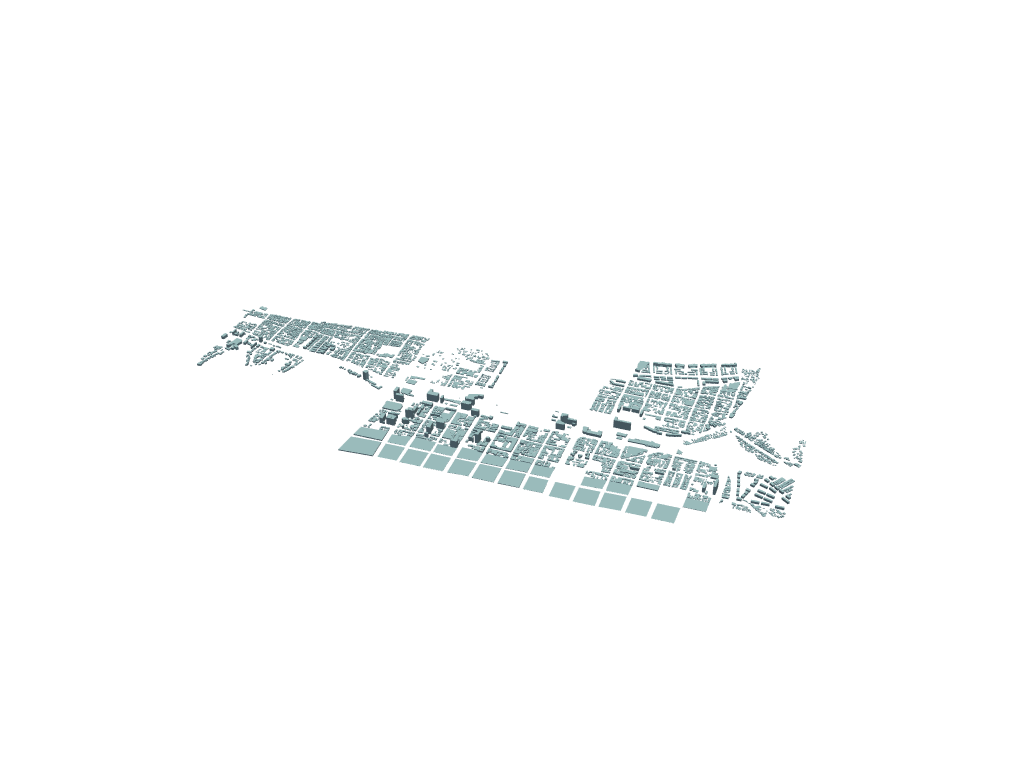

In [71]:
plotter.show()

In [72]:
# Exportar la escena actual como un archivo .obj
plotter.export_obj("escena_completa_ed.obj")

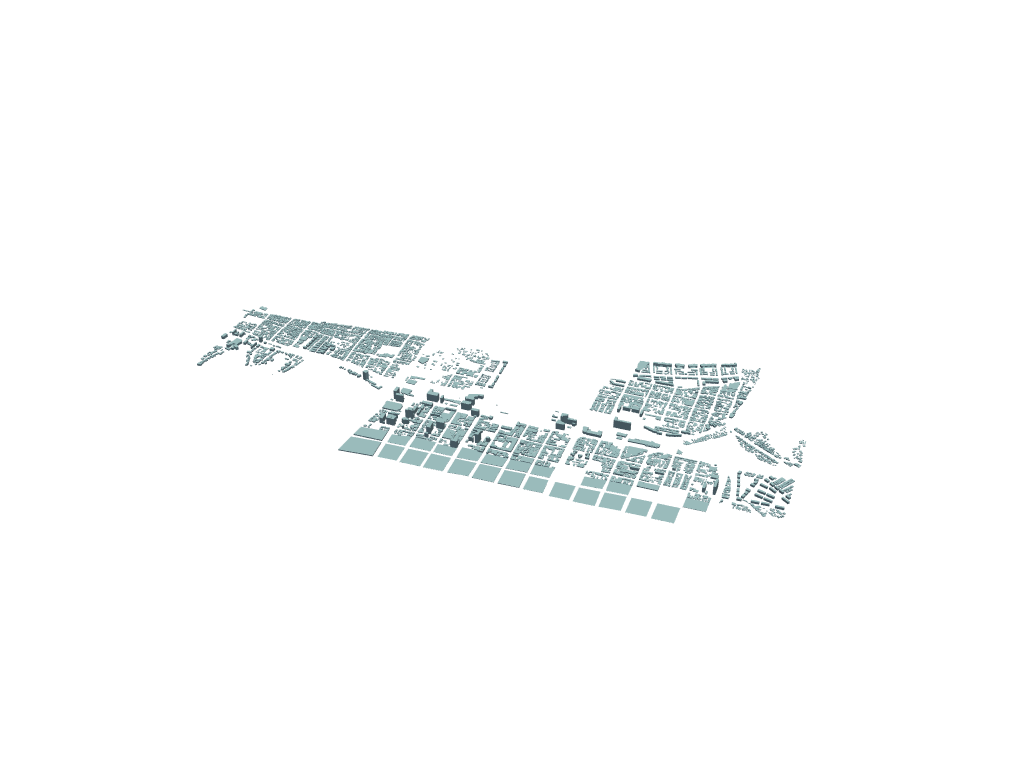

In [75]:
plotter.show()

In [73]:
plotter.add_mesh(malla_terreno)

Actor (0x7f7158c27400)
  Center:                     (673002.1140715803, 5922075.157992436, 81.77995048460018)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    6.716E+05, 6.744E+05
  Y Bounds                    5.920E+06, 5.924E+06
  Z Bounds                    -5.983E+00, 1.695E+02
  User matrix:                Unset
  Has mapper:                 True

Property (0x7f7158c27a60)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=2

In [33]:
plotter = pv.Plotter()

for index, row in summary_z.iterrows():
    print(index)
    # Crear malla para el edificio
    main_mesh, side_meshes = create_prism_mesh_and_sides(row['geometry'], row['Height'], h0=row['max_z'])

    plotter.add_mesh(main_mesh)  # Añadir el edificio
    # Añadir cada malla de cara lateral con su textura
    for side_mesh in side_meshes:
        plotter.add_mesh(side_mesh)

    # Crear malla base (desde la altura mínima a la máxima)
    base_mesh, side_meshes = create_prism_mesh_and_sides(row['geometry'], row['max_z'] - row['min_z'], h0=row['min_z'])

    plotter.add_mesh(base_mesh, color='grey')  # Añadir la base
    # Añadir cada malla de cara lateral con su textura
    for side_mesh in side_meshes:
        plotter.add_mesh(side_mesh, color='grey')

# Guardar la escena como archivo .obj
plotter.show(auto_close=False)
plotter.export_obj("escena_edificios.obj")
plotter.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

## Agregar edificaciones al plot

In [167]:
def get_height_values(mesh, gdf, agg_functions_str):
    """
    Obtiene valores de altura para cada polígono en un GeoDataFrame basado en una malla.
    Cada función de agregación en agg_functions_str resulta en una columna separada.

    :param mesh: Malla de PyVista para analizar.
    :param gdf: GeoDataFrame con la columna 'geometry'.
    :param agg_functions_str: Lista de strings que indican las funciones de agregación ('min', 'max', 'mean').
    :return: DataFrame con los valores de altura para cada ID en gdf.
    """
    agg_functions = {
        'min': np.min,
        'max': np.max,
        'mean': np.mean
    }

    # Verificar que todas las funciones de agregación son válidas
    for func in agg_functions_str:
        if func not in agg_functions:
            raise ValueError(f"Función de agregación '{func}' no es válida. Usa 'min', 'max' o 'mean'.")

    # Diccionario para almacenar los resultados
    resultados = {'ID': []}
    for func in agg_functions_str:
        resultados[func] = []

    # Procesar cada polígono en el GeoDataFrame
    for idx, row in gdf.iterrows():
        puntos = generar(row['geometry'], num_puntos=100)
        pv_puntos = np.array([[p[0], p[1], 0] for p in puntos])
        _, elevaciones = mesh.sample_points_uniformly(number_of_points=100, points=pv_puntos)

        # Agregar ID y calcular cada valor de agregación
        resultados['ID'].append(idx)
        for agg_func_str in agg_functions_str:
            agg_func = agg_functions[agg_func_str]
            resultados[agg_func_str].append(agg_func(elevaciones['vtkValidPointMask']))

    # Convertir el diccionario en un DataFrame
    return pd.DataFrame(resultados)

# Ejemplo de uso
functions_list = ['min', 'max', 'mean']
heights_df = get_height_values(malla_terreno, edificaciones_gdf, functions_list)


AttributeError: 'StructuredGrid' object has no attribute 'sample_points_uniformly'